## Neural Style Transfer

**In this notebook I use Neural Style Transfer to combine content and style images, which results in the clreation of generated images**

In [3]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
from PIL import Image 

%matplotlib inline

## 1 - Problem Statement

As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, I am going to generate an image of the an inteligent robot (content image C), mixed with a painting (style image S).

<img src="images/machine.jpeg" style="width:400px;height:300px;">
<img src="images/painting.jpeg" style="width:400px;height:300px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that.

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

After downloading the model from [this link](https://www.vlfeat.org/matconvnet/models/), run the following code to load parameters from the VGG model. This may take a few seconds. 

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

* The model is stored in a python dictionary.  
* The 'key' is the variable name and the 'value' is a tensor for that layer. 

#### Instruction (input image to the model's input layer)
To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:  
```python
model["input"].assign(image)
```
This assigns the image as an input to the model. 

#### Activate a layer
After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:  
```python
sess.run(model["conv4_2"])
```

In [26]:
def img_reshape(image_name, width, height):
    img = Image.open('images/' + image_name)
    img = img.resize((width, height), Image.ANTIALIAS) 
    img.save('images/' + image_name)
    

(300, 400, 3)


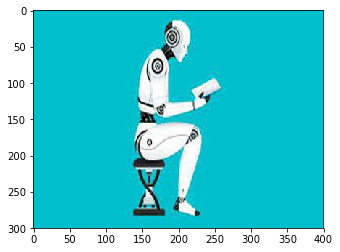

In [31]:
image_name = 'machine.jpeg'
img_reshape(image_name, 400,300)
content_image = scipy.misc.imread("images/machine.jpeg")
print(content_image.shape)
imshow(content_image);

In [32]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    # compute the cost with tensorflow 
    J_content = 1/(4*n_H*n_C*n_W)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    
    return J_content

In [33]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


(300, 400, 3)


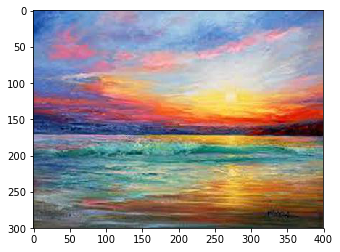

In [35]:
image_name = 'painting.jpeg'
img_reshape(image_name, 400,300)
style_image = scipy.misc.imread("images/painting.jpeg")
print(style_image.shape)
imshow(style_image);

In [36]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [37]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [38]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.transpose(tf.reshape(a_S,shape=[-1,n_C]),perm=[1,0])
    a_G = tf.transpose(tf.reshape(a_G,shape=[-1,n_C]),perm=[1,0])

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = 1/(4*n_C**2*(n_H*n_W)**2)*tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    
    return J_style_layer

In [39]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


### 3.2.3 Style Weights

* So far I have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, I'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [40]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [41]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [42]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content + beta*J_style
    
    return J

In [43]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


#### Interactive Sessions

You've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. 
* To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". 
* Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  

#### Start the interactive session.

In [44]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [47]:
content_image = scipy.misc.imread("images/machine.jpeg")
content_image = reshape_and_normalize_image(content_image)

In [48]:
style_image = scipy.misc.imread("images/painting.jpeg")
style_image = reshape_and_normalize_image(style_image)

#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 


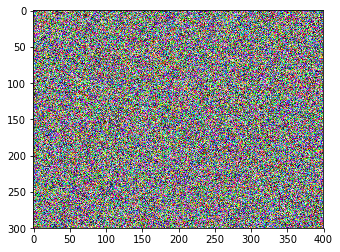

In [49]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [50]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [51]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [52]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [53]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [54]:
# define optimizer 
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step 
train_step = optimizer.minimize(J)

In [55]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [56]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 1.26937e+10
content cost = 18523.0
style cost = 3.17337e+08
Iteration 20 :
total cost = 2.25761e+09
content cost = 28474.0
style cost = 5.64332e+07
Iteration 40 :
total cost = 1.18171e+09
content cost = 30312.5
style cost = 2.9535e+07
Iteration 60 :
total cost = 7.40179e+08
content cost = 32069.6
style cost = 1.84964e+07
Iteration 80 :
total cost = 4.94056e+08
content cost = 33600.5
style cost = 1.2343e+07
Iteration 100 :
total cost = 3.56994e+08
content cost = 34818.6
style cost = 8.91616e+06
Iteration 120 :
total cost = 2.74931e+08
content cost = 35667.6
style cost = 6.86436e+06
Iteration 140 :
total cost = 2.22376e+08
content cost = 36271.9
style cost = 5.55033e+06
Iteration 160 :
total cost = 1.86556e+08
content cost = 36770.1
style cost = 4.65471e+06
Iteration 180 :
total cost = 1.60581e+08
content cost = 37169.3
style cost = 4.00524e+06


array([[[[ -68.68389893,   36.9893837 ,   57.85288239],
         [ -24.83484077,   44.76111603,   49.68508911],
         [ -51.72937775,   27.24284554,   35.07505417],
         ..., 
         [ -87.35356903,   78.04373932,   62.02163315],
         [-120.06587982,   92.40808868,   73.19400024],
         [-102.99984741,   89.50534058,   63.34701157]],

        [[ -64.55368805,   14.5594368 ,   35.89215088],
         [ -34.96984863,   41.7780571 ,   48.56306458],
         [ -27.92642403,   18.34982872,   43.109478  ],
         ..., 
         [ -70.68936157,   50.3783493 ,   64.54695129],
         [ -58.99980164,   48.52054596,   46.1314888 ],
         [ -72.37316895,   67.66059113,   60.68023682]],

        [[ -62.03092957,   21.24136162,   43.21961212],
         [ -48.21138763,   18.19072533,   42.36819458],
         [ -40.39478683,   15.75565815,   32.30614471],
         ..., 
         [ -45.68358612,   23.35954094,   63.8793869 ],
         [ -54.38107681,   37.11329269,   63.68595886],

## Here you can see a mixture of art and technology!


<img src="output/generated_image1.png" style="width:400px;height:300px;">

To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. 